#### Import needed modules

In [ ]:
import os
import random

import pickle as pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt


#### Load all available ecg data

In [4]:
# Load data
data_path = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\ecg_data.csv'
data = pd.read_csv(data_path, index_col=0)

# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [ ]:
outer = range(0,20)

best_params_dict = {}
best_model_dict = {}

# Initialize variables to store precision-recall data
precision_list = []
recall_list = []
auc_list = []

for outer_rand in tqdm(outer, desc='Outer Loop'):
    # Split data into outer folds
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
            x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand)
    
    # Scale features
    scaler = RobustScaler(quantile_range=(25, 75))
    X_train_outer = scaler.fit_transform(X_train_outer)     
    X_test_outer = scaler.transform(X_test_outer)
    
    # Apply PCA
    pca = PCA(n_components=0.95)  # Keep 95% variance
    X_train_outer = pca.fit_transform(X_train_outer)
    X_test_outer = pca.transform(X_test_outer)




    # Create a pipeline with scaling, PCA, and KNeighborsClassifier
    # FIXED: Use the same name without hyphens in both pipeline and param grid
    param_grid_knn = {
        'knn__n_neighbors': list(range(3, 25)),  # Iterate over k from 3 to 24
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }

    pipeline = Pipeline([
        ('knn', KNeighborsClassifier())  # FIXED: Changed 'K-NN' to 'knn'
    ])

    # For classification problems to maintain class distribution
    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
        
    random_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid_knn,
        scoring='roc_auc',
        cv=cv_inner,
        n_jobs=-1
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_params = random_search.best_params_
    best_params_dict[f"Outer {outer_rand}"] = best_params
    best_model_dict[f"Outer {outer_rand}"] = random_search.best_estimator_
    y_pred = best_model_dict[f"Outer {outer_rand}"].predict(X_test_outer)
    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()

    # Calculate metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    y_pred_proba = best_model_dict[f"Outer {outer_rand}"].predict_proba(X_test_outer)[:, 1]
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)
    
    # precision recall curve
    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(auc(recall, precision))

    best_params_dict[f"Outer {outer_rand}"]['auc'] = auc_score
    best_params_dict[f"Outer {outer_rand}"]['f1'] = f1
    best_params_dict[f"Outer {outer_rand}"]['sensitivity'] = sensitivity
    best_params_dict[f"Outer {outer_rand}"]['specificity'] = specificity
    best_params_dict[f"Outer {outer_rand}"]['accuracy'] = accuracy
    

    print(f"\nOuter {outer_rand} -> Best Hyperparameters: {best_params}")

    # Save results
    results_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'best_hyperparameters_short.csv')
    results_df.to_csv(results_csv_path)
    print(f"\nBest parameters saved to {results_csv_path} after Outer {outer_rand} completion")

    # Save precision-recall data
    pr_data = {
        "precision_list": precision_list,
        "recall_list": recall_list,
        "auc_list": auc_list
    }
    pr_data_path = os.path.join(os.getcwd(), 'precision_recall_data.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)
    print(f"\nPrecision-recall data saved to {pr_data_path} after Outer {outer_rand} completion")



Outer Loop:   5%|▌         | 1/20 [00:04<01:21,  4.29s/it]


Outer 0 -> Best Hyperparameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 11, 'knn__weights': 'uniform', 'auc': 0.541278630757614, 'f1': 0.1212121212121212, 'sensitivity': 0.06896551724137931, 'specificity': 0.9854014598540146, 'accuracy': 0.8253012048192772}

Best parameters saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\best_hyperparameters_short.csv after Outer 0 completion

Precision-recall data saved to e:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\precision_recall_data.pkl after Outer 0 completion


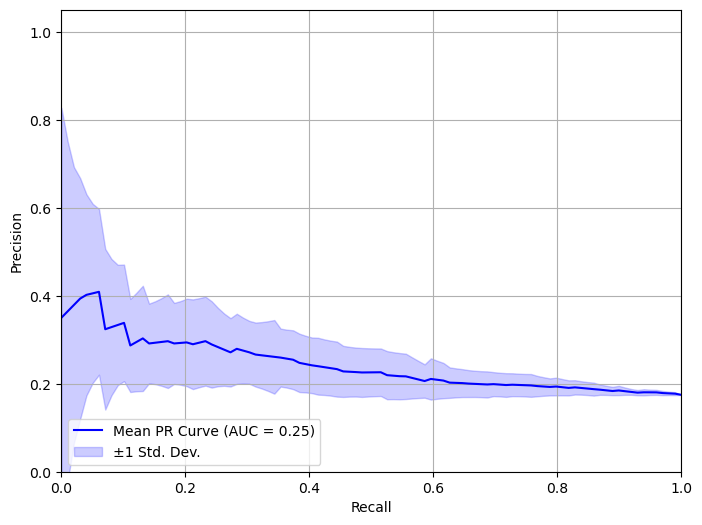

In [11]:
# Load precision-recall data from pickle file
pr_data_path = os.path.join(os.getcwd(), 'precision_recall_data.pkl')
with open(pr_data_path, 'rb') as f:
    pr_data = pickle.load(f)

# Extract precision, recall, and AUC lists
precision_list = pr_data["precision_list"]
recall_list = pr_data["recall_list"]
auc_list = pr_data["auc_list"]

# Calculate mean and standard deviation for precision-recall curves
mean_recall = np.linspace(0, 1, 100)
interp_precisions = []

for precision, recall in zip(precision_list, recall_list):
    # Sort recall and precision in increasing recall order
    order = np.argsort(recall)
    recall_sorted = recall[order]
    precision_sorted = precision[order]
    
    # Interpolate precision as a function of recall
    interp_precision = np.interp(mean_recall, recall_sorted, precision_sorted, left=1.0, right=0.0)
    interp_precisions.append(interp_precision)

# Calculate mean and std of precision at each recall level
mean_precision = np.mean(interp_precisions, axis=0)
std_precision = np.std(interp_precisions, axis=0)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, label=f"Mean PR Curve (AUC = {np.mean(auc_list):.2f})", color='b')
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, color='b', alpha=0.2, label="±1 Std. Dev.")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")
plt.grid()
plt.show()